In [2]:
##################
## Load Imports ##
##################

import math
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

from plotting_helpers import plot_toy_data, plot_training, plot_predictions
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

%matplotlib inline
%load_ext autoreload
%autoreload 2

np.random.seed(111)

# 4 Bayesian Neural Networks (BNNs)

In this exercise, we will learn how to perform approximate Bayesian inference in neural network models. We will use the same regression dataset as in the first exercise and will do the following:

1. Implement the reparameterization trick for a variational linear transformation (Section [4.3](#4.3.1-Implementing-the-ELBO)).
2. Implement the KL divergence between the variational distribution q and the prior p (Section [4.3](#4.3.1-Implementing-the-ELBO)).
3. Explore the effects of hyperparameters on inference in BNNS (Section [4.4](#4.4-Understanding-the-Effects-of-Hyperparameters-on-BNNs)).

## 4.1 Preparing Toy Data

We first prepare the same 1D toy dataset as in exercise 1.

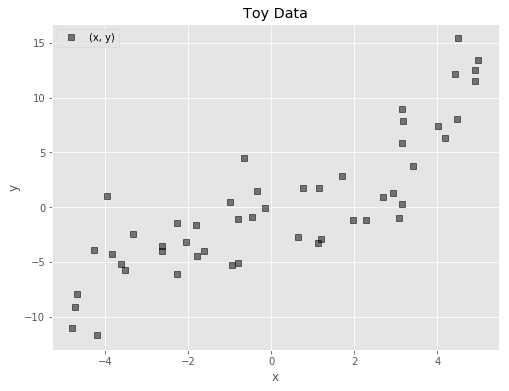

In [3]:
#####################
## Sample Toy Data ##
#####################

def toy_data(N, sigma, seed=111):
    np.random.seed(seed)
    x = np.random.uniform(-5, 5, size=N)
    np.random.seed(seed)
    y = 0.1 * x**3 + np.random.normal(0.0, sigma, size=N)
    return x, y

N = 50
sigma = 3.0

x, y = toy_data(N, sigma)

xt, yt = torch.FloatTensor(x.reshape([-1,1])), torch.FloatTensor(y)

plot_toy_data(x, y)

## 4.2 Model Specification

We use a neural network with a single hidden layer.
This neural network outputs the predicted mean:
$$\mu(x) = g(x \boldsymbol{a}_0 + \boldsymbol{b}_0) \boldsymbol{a}_1 + b_1.$$
For the activation function $g(\cdot)$, we will use ReLU.
Denote the combination of all the parameters by $\boldsymbol{w} = (\boldsymbol{a}_0, \boldsymbol{b}_0, \boldsymbol{a}_1, b_1)$.

Assume that we have $N$ data points $\mathcal{D} = \{(x_n,y_n)\}_{n=1}^N$.

The likelihood of the model is given by
$$p(\mathcal{D} | \boldsymbol{w})  = \prod_{n=1}^N \mathcal{N}(y_n | \mu_{\boldsymbol{w}}(x), \tau^{-1}),$$
where $\tau$ is the noise precision.

For the prior, we will continue to assume a Gaussian distribution.
$$p(\boldsymbol{w}) = \mathcal{N}(\boldsymbol{w} | 0, \lambda^{-1} \boldsymbol{I}),$$
where $\lambda$ is the prior precision. Note that this prior is non-conjugate to the likelihood (see discussion in earlier exercises). We therefore consider approximate methods for Bayesian inference.

## 4.3 Approximate Inference in BNNs

Now we use variational inference to obtain an approximation $q(\boldsymbol{w})$ to the true posterior $p(\boldsymbol{w} | \mathcal{D})$.

For the variational distribution, we use a fully-factorized (mean-field) Gaussian:
$$q(\boldsymbol{w} | \boldsymbol{\phi}) = \mathcal{N}((\boldsymbol{w} | (\boldsymbol{\boldsymbol{\mu}}, \mathrm{diag}((\boldsymbol{\sigma^2})),$$
where each parameter $w_d$ has a mean $m_d$ and a precision $s_d$, and $\boldsymbol{\phi}$ denotes the combination of all the variational parameters. Notice that this factorization implies independence between the different parameters $w_d$.

### 4.3.1 Implementing the ELBO

The ELBO is given by
$$\mathcal{L}(\boldsymbol{\phi}) = \mathbb{E}_{q(\boldsymbol{w}|\boldsymbol{\phi})} [\log p(y | x, \boldsymbol{w})] - \mathbb{D}_{KL}[q(\boldsymbol{w}|\boldsymbol{\phi}) \| p(\boldsymbol{w})].$$

To optimize the ELBO, we use of reparameterization trick as our gradient estimator and use the automatic differentiation built into PyTorch to avoid computing the gradients by hand.

### Your Tasks:
* Apply the **reparameterization trick** to neural networks by computing the stochastic forward pass through a neural network layer in ```StochasticLinear.forward()```.
* Finish implementing the ELBO by computing the **KL divergence** between $q(\boldsymbol{w} | \boldsymbol{\phi})$ and the prior $p(\boldsymbol{w})$ in ```StochasticLinear.kl_divergence()```.

In [29]:
#########################################################
## Define Stochastic Variational Linear Transformation ##
#########################################################

class StochasticLinear(nn.Module):

    def __init__(self, in_features, out_features):
        super(StochasticLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight_mu = nn.Parameter(torch.Tensor(out_features, in_features))
        self.weight_rho = nn.Parameter(torch.Tensor(out_features, in_features))
        self.bias_mu = nn.Parameter(torch.Tensor(out_features))
        self.bias_rho = nn.Parameter(torch.Tensor(out_features))
        self.reset_parameters()

    def reset_parameters(self):
        self.weight_mu.data.normal_(0,0.1)
        self.bias_mu.data.normal_(0,0.1)
        self.weight_rho.data.normal_(-2)
        self.bias_rho.data.normal_(-2)

### TASKS BEGIN ###
    def forward(self, input):
        ### Implement the reparameterization trick ###
        ### Hint: Use torch.normal(...) to sample from a Gaussian ###
        ### Hint: Use sigma = F.softplus(rho) ###
        weight = self.weight_mu
        bias = self.bias_mu
        return F.linear(input, weight, bias)

    def kl_divergence(self, lam=0.01):
        ### Implement the KL divergence between q and the prior p ###
        ### Hint: Compute the KL for both the weight and the bias ###
        ### Hint: Use self._kl_gaussian(...) to compute the KL divergence ###
        kl_w = 0
        kl_b = 0
        return kl_w + kl_b
### TASKS END ###
    
    def _kl_gaussian(self, q_mu, q_sigma, p_mu, p_sigma):
        var_ratio = (q_sigma / p_sigma).pow(2)
        t1 = ((q_mu - p_mu) / p_sigma).pow(2)
        return 0.5 * torch.sum((var_ratio + t1 - 1 - var_ratio.log()))


In [30]:
##################
## Define Model ##
##################

class NeuralNet(nn.Module):
    def __init__(self, hidden_units):
        super(NeuralNet, self).__init__()
        self.layer1 = StochasticLinear(1, hidden_units)
        self.layer2 = StochasticLinear(hidden_units, 1)
        
    def forward(self, x):
        h = F.relu(self.layer1(x))
        z = self.layer2(h)
        return z.reshape([-1])
    
    def kl_divergence(self):
        kl1 = self.layer1.kl_divergence()
        kl2 = self.layer2.kl_divergence()
        return kl1 + kl2

net = NeuralNet(hidden_units = 2)

### 4.3.2 The Training Objective

For training, we use the negative ELBO as the objective. This is consistent with the previous exercises.

In [31]:
######################
## Define objective ##
######################

def neg_loglik(y, mu, sigma):
    logprobs = 0.5 * (- math.log(2 * math.pi) - math.log(sigma**2) - (1/sigma**2) * (y - mu)**2)
    loglik = torch.sum(logprobs)
    return -loglik

def neg_elbo(y, mu_list, sigma, kl):    
    neg_loglik_list = [neg_loglik(y, mu, sigma) for mu in mu_list]    
    neg_loglik_tensor = torch.stack(neg_loglik_list, dim = 0)
    mc_neg_loglik = torch.mean(neg_loglik_tensor)
    neg_elbo = mc_neg_loglik + kl
    return neg_elbo

### 4.3.3 Training the Model with Gradient Descent

We minimize the negative ELBO using gradient descent
$$\boldsymbol{\phi} \leftarrow \boldsymbol{\phi} - \alpha \nabla_{\boldsymbol{\phi}}( - \mathcal{L}(\boldsymbol{\phi})),$$
where $\alpha$ is the learning rate. The gradients are computed in *loss.backward()* using **automatic differentiation**.

In [32]:
#####################
## Define training ##
#####################
    
def train(num_iters, learning_rate, mc_samples):
    
    losses = []
    
    for i in range(num_iters):
        
        # Clear gradient buffers
        net.zero_grad()
        
        # Forward pass
        mu_pred_list = [net(xt) for _ in range(mc_samples)]
        loss = neg_elbo(yt, mu_pred_list, sigma, kl = net.kl_divergence())
        
        # Backward pass
        loss.backward()
        
        # Update weights using gradient descent
        with torch.no_grad():
            for param in net.parameters():
                if param.grad is not None:
                    param -= learning_rate * param.grad
        
        # Store loss
        losses.append(loss.detach().item())
        
        # Print progress
        if (i+1) % 50 == 0:
            print('Iter [{}/{}], ELBO: {:.4f}'.format(i+1, num_iters, losses[-1]))
    
    return losses


Iter [50/500], ELBO: 192.6593
Iter [100/500], ELBO: 178.8157
Iter [150/500], ELBO: 174.6163
Iter [200/500], ELBO: 172.9775
Iter [250/500], ELBO: 172.1505
Iter [300/500], ELBO: 172.3729
Iter [350/500], ELBO: 171.3923
Iter [400/500], ELBO: 172.0562
Iter [450/500], ELBO: 171.4251
Iter [500/500], ELBO: 168.0119


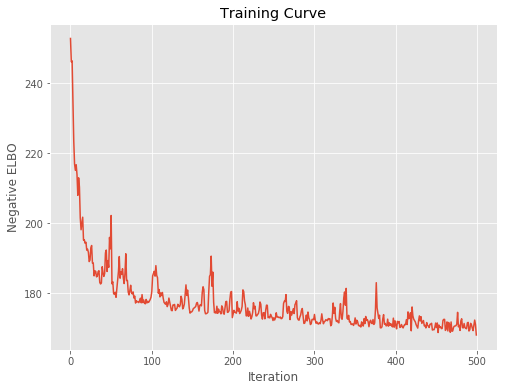

In [33]:
#################
## Train model ##
#################
    
torch.manual_seed(111)

losses = train(num_iters = 500, learning_rate = 0.01, mc_samples = 10)

plot_training(losses)

### 4.3.4 Making Predictions with BNNs

To predict, we use the approximate predictive distribution
$$p(y^* | x^*, \mathcal{D}) = \int p(y^* | x^*, \boldsymbol{w}) p(\boldsymbol{w} | \mathcal{D}) d\boldsymbol{w} \approx \int p(y^* | x^*, \boldsymbol{w}) q(\boldsymbol{w} | \boldsymbol{\phi}) d\boldsymbol{w}.$$

In practice, we approximate this integral using $S$ Monte Carlo samples
$$\int p(y^* | x^*, \boldsymbol{w}) q(\boldsymbol{w} | \boldsymbol{\phi}) d\boldsymbol{w} \approx \frac{1}{S} \sum_{s=1}^S p(y^* | x^*, \boldsymbol{w}^{(s)}), \quad\quad\mathrm{where}\quad \boldsymbol{w}^{(s)} \sim q(\boldsymbol{w} | \boldsymbol{\phi}).$$

Visualizations of the means $\mu_{\boldsymbol{w}^{(s)}}(x^*)$ of several Monte Carlo samples are shown below.

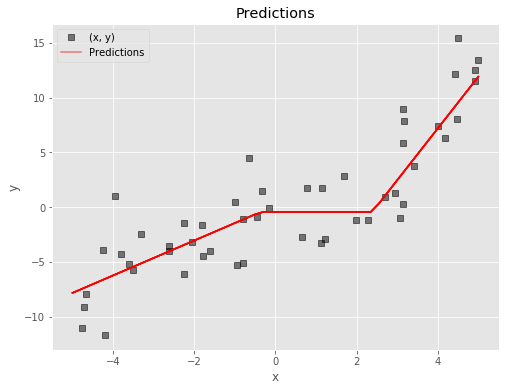

In [23]:
########################
## Sample Predictions ##
########################

num_preds = 10
resolution = 50

x_pred = np.linspace(-5, 5, num=resolution)
xt_pred = torch.FloatTensor(x_pred.reshape([-1,1]))
mu_pred = np.array([net(xt_pred).detach().numpy() for _ in range(num_preds)])

######################
## Plot predictions ##
######################

plot_predictions(x, y, x_pred, mu_pred)

## 4.4 Understanding the Effects of Hyperparameters on BNNs

The various hyperparameters of a BNN can strongly affect the model that is learned, it's training curve, and its predictions.

### Your Tasks: 
* Try varying the following hyperparameters to determine their effects on the BNN we trained above:
    * The number of hidden units
    * The prior precision $\lambda$
    * The learning rate $\alpha$
    * The number of training MC samples
    * The initial precision of $q$
    * The number of data points $N$

You can also try to sample different toy datasets.